In [665]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

import fuzzywuzzy
from fuzzywuzzy import process
import chardet

earthquakes = pd.concat([pd.read_csv("datasets/earthquake2019/"+ month +" 2019.csv") for month in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']])


In [666]:
#RENAME COLUMNS
earthquakes = pd.DataFrame(earthquakes.rename(columns={'Date - Time\n(Philippine Time)':'Datetime',
                                                       'Latitude\n(ºN)':'Latitude',
                                                       'Longitude\n(ºE)':'Longitude',
                                                       'Depth\n(km)':'Depth'}))
#PARSE TO DATETIME
earthquakes.Datetime = pd.to_datetime(earthquakes.Datetime, format="%d %B %Y - %I:%M %p")
#ADDITIONAL DATE COLUMNS
earthquakes['Month'] = earthquakes.Datetime.dt.month
earthquakes['Day'] = earthquakes.Datetime.dt.day
#SPLIT PROVINCE AND REGION FROM LOCATION
location = earthquakes['Location'].str.split('of ', n=1, expand=True)
location = location[1].str.split('(', n=1, expand=True)
earthquakes['Province'] = location[0]
region = location[1].str.split(')', n=1, expand=True)
earthquakes['Region'] = region[0]

In [344]:
#FUZZYWUZZY FUNCTION
def replace_matches_in_column(df, column, string_to_match, min_ratio=90):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    
    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    
    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)
    
    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

#CLEANING INCONSISTENT DATA USING FUZZYWUZZY
for province in earthquakes.Province.sort_values().unique():
    replace_matches_in_column(earthquakes, 'Province', str(province))
for region in earthquakes.Region.sort_values().unique():
    replace_matches_in_column(earthquakes, 'Region', str(region))
    
earthquakes.Region.replace('Cotabato','North Cotabato', inplace=True)
earthquakes.Region.replace('Occ.mindoro','Occidental Mindoro', inplace=True)
earthquakes.Region.replace('S.leyte','Southern Leyte', inplace=True)
earthquakes.Region.replace('Masbate (Ticao Island', 'Masbate (Ticao Island)', inplace=True)

In [556]:
earthquakes.loc[earthquakes.Mag > 5].groupby('Month').size()

Month
1     6
2     5
3     6
4     8
5     4
6     2
7     7
8     2
9     6
10    9
11    4
12    5
dtype: int64

## Distribution

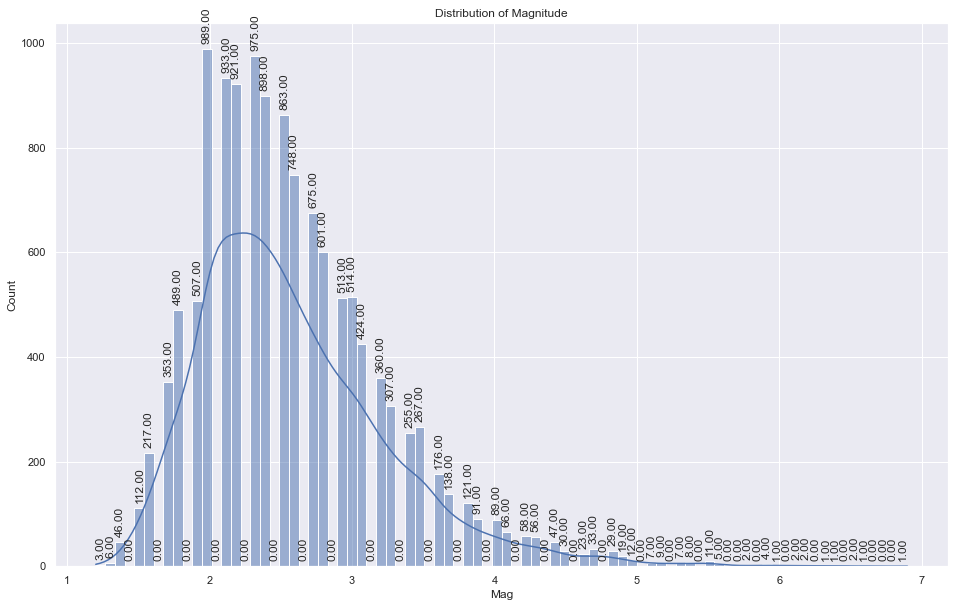

In [473]:
# plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(figsize=(16, 10))
sns.histplot(earthquakes.Mag, kde=True)
plt.title('Distribution of Magnitude')
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{"{:.2f}".format(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', rotation=90)

In [609]:
earthquakes.Mag.describe()

count    13028.000000
mean         2.581770
std          0.664875
min          1.200000
25%          2.100000
50%          2.500000
75%          2.900000
max          6.900000
Name: Mag, dtype: float64

## Cumulative 

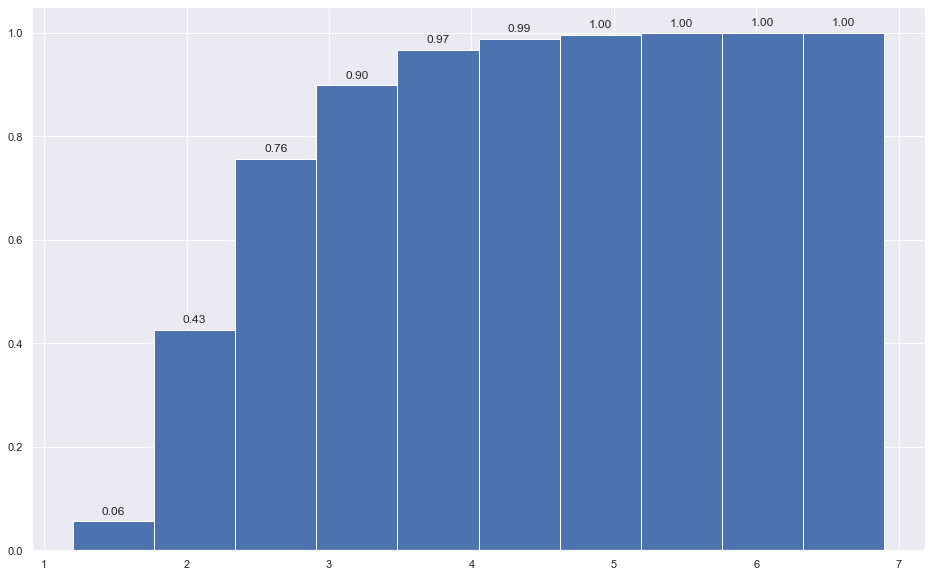

In [347]:
import math

fig, ax = plt.subplots(figsize=(16, 10))
ax.hist(earthquakes.Mag, cumulative=True, density=True)
# ax.title("Cumulative Frequency of Earthquakes 2019")
# ax.xlabel("Mag")
# ax.ylabel("Frequency")

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{"{:.2f}".format(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')


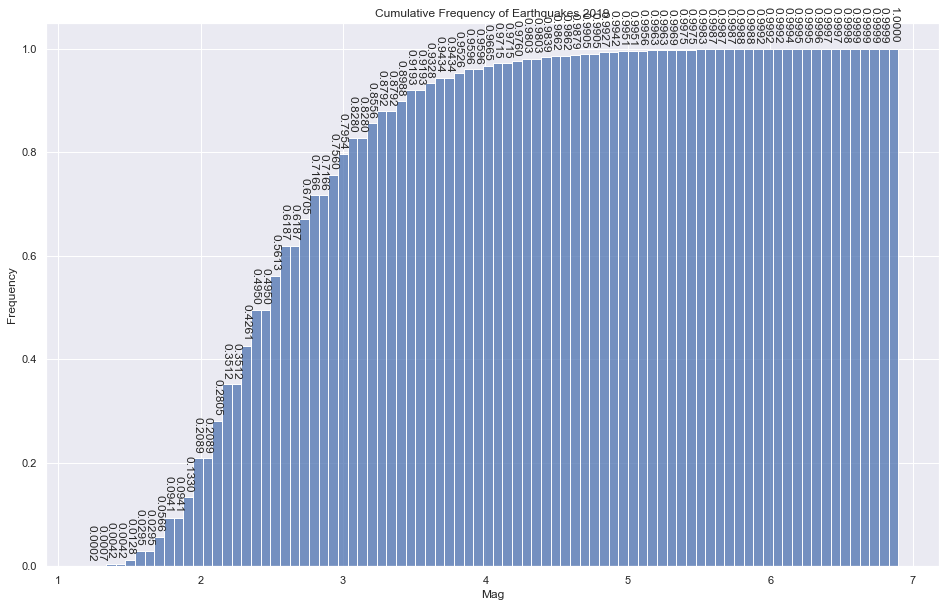

In [348]:
import math

fig, ax = plt.subplots(figsize=(16, 10))
sns.histplot(earthquakes.Mag, cumulative=True, stat='density')
plt.title("Cumulative Frequency of Earthquakes 2019")
plt.xlabel("Mag")
plt.ylabel("Frequency")

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{"{:.4f}".format(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', rotation=-90)

## Monthly Periodicity

In [77]:
day_of_month_earthquake = earthquakes.Datetime.dt.day

In [78]:
day_of_month_earthquake.head()

0    31
1    31
2    31
3    31
4    31
Name: Datetime, dtype: int64

<AxesSubplot:xlabel='Datetime', ylabel='Count'>

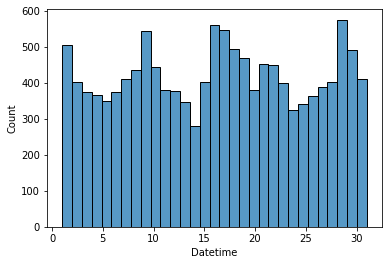

In [79]:
sns.histplot(day_of_month_earthquake, kde=False, bins=31)

## Earthquake Frequency and Magnitude By Region

In [345]:
earthquakes.Region.value_counts()

North Cotabato        2001
Surigao del Norte     1570
Davao Occidental       990
Davao Oriental         924
Surigao del Sur        760
                      ... 
Don Mariano Marcos       1
San Isidro               1
Basilan                  1
Tongkil                  1
San Andres               1
Name: Region, Length: 116, dtype: int64

In [349]:
year_earthquake = earthquakes.copy()
year_earthquake['Region'] = pd.Categorical(year_earthquake['Region'], categories = [region for region in year_earthquake.Region.sort_values().unique()], ordered=True)
year_earthquake = year_earthquake.groupby(['Month', 'Region']).size().unstack(fill_value=0)

Text(0, 0.5, 'Month')

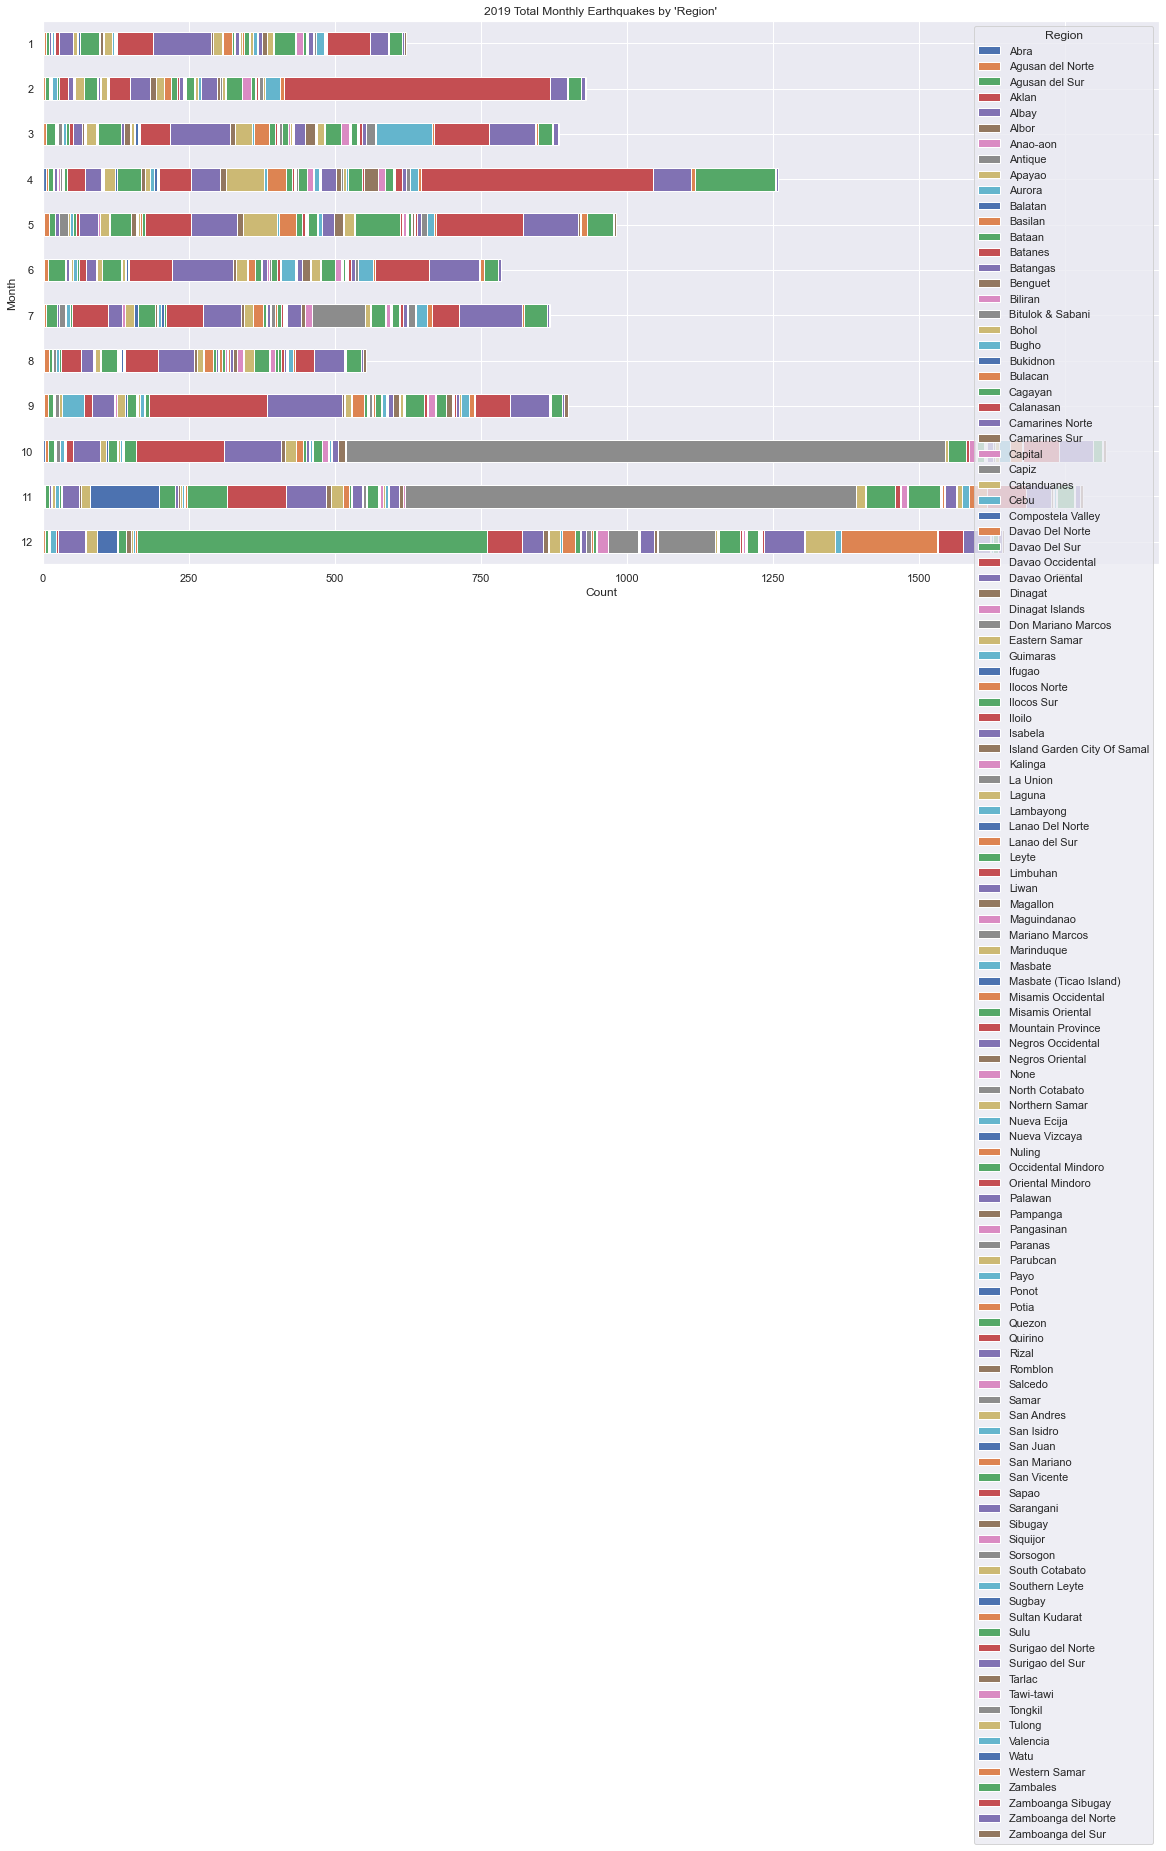

In [547]:
plt.rcParams["figure.figsize"] = (20,10)
year_earthquake.plot.barh(stacked=True).invert_yaxis()
plt.title("2019 Total Monthly Earthquakes by 'Region'")
plt.xlabel("Count")
plt.ylabel("Month")

Text(0, 0.5, 'Month')

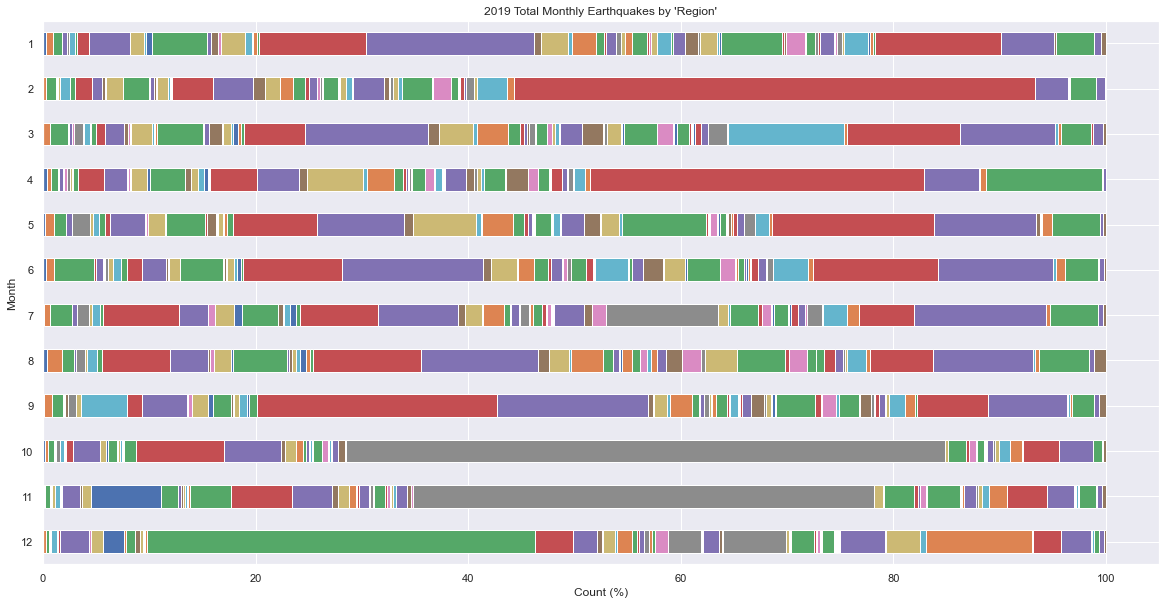

In [351]:
stacked_data = year_earthquake.apply(lambda x: x*100/sum(x), axis=1)
plt.rcParams["figure.figsize"] = (20,10)
stacked_data.plot.barh(stacked=True, legend=None).invert_yaxis()
plt.title("2019 Total Monthly Earthquakes by 'Region'")
plt.xlabel("Count (%)")
plt.ylabel("Month")


In [360]:
earthquake_mag = earthquakes.copy()
earthquake_mag['Region'] = pd.Categorical(earthquake_mag['Region'], categories = [region for region in earthquake_mag.Region.sort_values().unique()], ordered=True)
earthquake_mag = earthquake_mag.groupby(['Month', 'Region']).agg({'Mag':'max'}).unstack(fill_value=0)

Text(0, 0.5, 'Month')

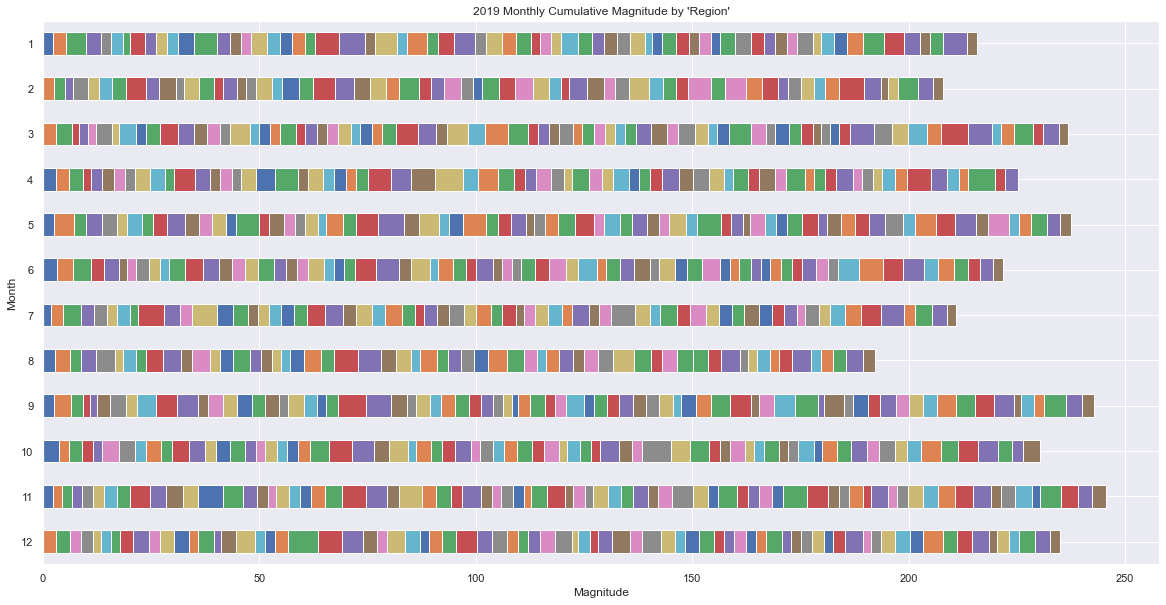

In [365]:
plt.rcParams["figure.figsize"] = (20,10)
earthquake_mag.plot.barh(stacked=True, legend=None).invert_yaxis()
plt.title("2019 Monthly Cumulative Magnitude by 'Region'")
plt.xlabel("Magnitude")
plt.ylabel("Month")

In [536]:
earthquake_agg = earthquakes.copy()
earthquake_agg = earthquake_agg.groupby('Month').agg({'Mag':['mean', 'max']}, inplace=True)
earthquake_agg

Mag     
           mean  max
Month               
1      2.648792  6.0
2      2.620753  5.9
3      2.531222  6.2
4      2.541223  6.5
5      2.635780  6.2
6      2.594013  5.4
7      2.647641  5.9
8      2.625271  5.6
9      2.667964  6.4
10     2.602802  6.6
11     2.493487  5.9
12     2.530334  6.9

In [448]:
earthquakes_6 = earthquakes.copy()
earthquakes_6 = earthquakes_6.loc[earthquakes_6.Mag > 5.9]
earthquakes_6.sort_values(by=['Month', 'Day'])

,Datetime,Latitude,Longitude,Depth,Mag,Location,Month,Day,Province,Region
319,2019-01-16 04:03:00,5.95,126.87,40,6.0,117 km S 49° E of Governor Generoso (Davao Ori...,1,16,Governor Generoso,Davao Oriental
651,2019-03-08 23:06:00,10.37,126.13,17,6.2,039 km N 09° E of Burgos (Surigao Del Norte),3,8,Burgos,Surigao del Norte
624,2019-04-22 17:11:00,15.02,120.34,10,6.1,018 km N 58° E of Castillejos (Zambales),4,22,Castillejos,Zambales
541,2019-04-23 13:37:00,11.79,125.37,61,6.5,010 km N 65° W of San Julian (Eastern Samar),4,23,San Julian,Eastern Samar
18,2019-05-31 18:12:00,6.15,126.7,78,6.2,088 km S 51° E of Governor Generoso (Davao Ori...,5,31,Governor Generoso,Davao Oriental
143,2019-09-29 10:02:00,5.52,126.66,63,6.4,123 km S 71° E of Jose Abad Santos (Davao Occi...,9,29,Jose Abad Santos,Davao Occidental
1366,2019-10-16 19:37:00,6.76,125.01,9,6.3,023 km S 62° E of Tulunan (Cotabato),10,16,Tulunan,North Cotabato
549,2019-10-29 10:42:00,6.86,125.01,9,6.1,021 km S 90° E of Tulunan (Cotabato),10,29,Tulunan,North Cotabato
573,2019-10-29 09:04:00,6.81,125.03,7,6.6,022 km S 79° E of Tulunan (Cotabato),10,29,Tulunan,North Cotabato
190,2019-10-31 09:11:00,6.92,125.06,8,6.5,027 km N 75° E of Tulunan (Cotabato),10,31,Tulunan,North Cotabato


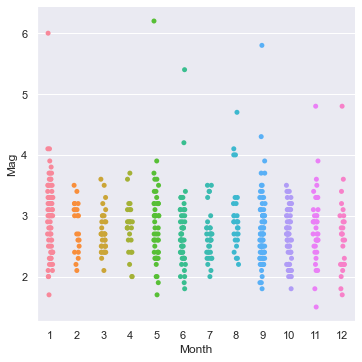

In [510]:
earthquake_6_region = earthquakes.loc[earthquakes.Province == 'Governor Generoso ']
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=earthquake_6_region.Month, y=earthquake_6_region.Mag, data=earthquake_6_region)

In [511]:
earthquake_6_region.describe()

,Mag,Month,Day
count,538.000000,538.000000,538.000000
mean,2.796840,6.446097,13.895911
std,0.557068,3.458436,9.406224
min,1.500000,1.000000,1.000000
25%,2.400000,3.000000,5.000000
50%,2.700000,6.500000,12.500000
75%,3.100000,9.000000,21.750000
max,6.200000,12.000000,31.000000


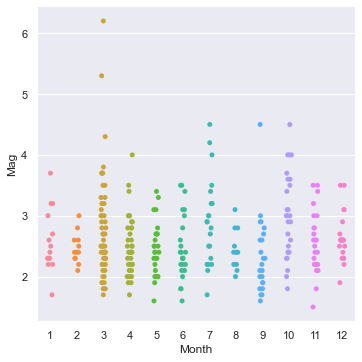

In [533]:
earthquake_6_region = earthquakes.loc[earthquakes.Province == 'Burgos ']
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=earthquake_6_region.Month, y=earthquake_6_region.Mag, data=earthquake_6_region)

In [513]:
earthquake_6_region.describe()

,Mag,Month,Day
count,300.000000,300.000000,300.000000
mean,2.620333,6.290000,14.293333
std,0.620890,3.328086,8.512471
min,1.500000,1.000000,1.000000
25%,2.200000,3.000000,8.000000
50%,2.500000,6.000000,13.000000
75%,2.925000,9.000000,22.000000
max,6.200000,12.000000,31.000000


Text(0.5, 1.0, 'Zambales')

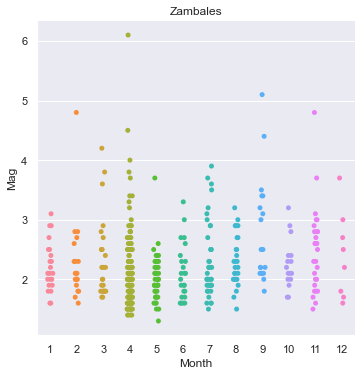

In [537]:
earthquake_6_region = earthquakes.loc[earthquakes.Region == 'Zambales']
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=earthquake_6_region.Month, y=earthquake_6_region.Mag, data=earthquake_6_region)
plt.title("Zambales")

In [515]:
earthquake_6_region.describe()

,Mag,Month,Day
count,413.000000,413.000000,413.000000
mean,2.225424,5.549637,18.472155
std,0.626058,2.795729,8.462500
min,1.300000,1.000000,1.000000
25%,1.800000,4.000000,12.000000
50%,2.100000,5.000000,22.000000
75%,2.500000,7.000000,25.000000
max,6.100000,12.000000,31.000000


Text(0.5, 1.0, 'Eastern Samar')

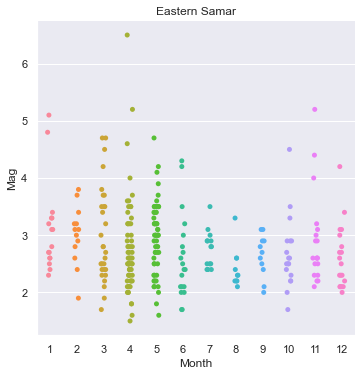

In [538]:
earthquake_6_region = earthquakes.loc[earthquakes.Region == 'Eastern Samar']
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=earthquake_6_region.Month, y=earthquake_6_region.Mag, data=earthquake_6_region)
plt.title("Eastern Samar")

In [517]:
earthquake_6_region.describe()

,Mag,Month,Day
count,292.000000,292.000000,292.000000
mean,2.826027,5.791096,16.373288
std,0.702187,3.089866,8.792044
min,1.500000,1.000000,1.000000
25%,2.300000,4.000000,8.000000
50%,2.700000,5.000000,17.000000
75%,3.200000,8.000000,23.250000
max,6.500000,12.000000,31.000000


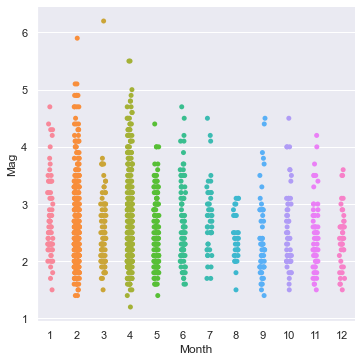

In [534]:
earthquake_6_region = earthquakes.loc[earthquakes.Region == 'Surigao del Norte']
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=earthquake_6_region.Month, y=earthquake_6_region.Mag, data=earthquake_6_region)

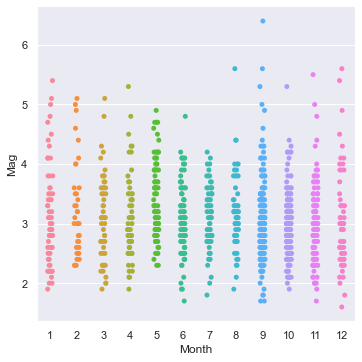

In [518]:
earthquake_6_region = earthquakes.loc[earthquakes.Region == 'Davao Occidental']
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=earthquake_6_region.Month, y=earthquake_6_region.Mag, data=earthquake_6_region)

In [519]:
earthquake_6_region.describe()

,Mag,Month,Day
count,990.000000,990.000000,990.000000
mean,3.099798,7.463636,15.684848
std,0.678591,3.176027,9.556901
min,1.600000,1.000000,1.000000
25%,2.600000,5.000000,7.000000
50%,3.000000,9.000000,15.000000
75%,3.500000,10.000000,24.000000
max,6.400000,12.000000,31.000000


Text(0.5, 1.0, 'North Cotabato')

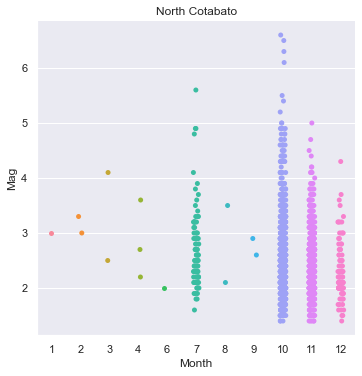

In [539]:
earthquake_6_region = earthquakes.loc[earthquakes.Region == 'North Cotabato']
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=earthquake_6_region.Month, y=earthquake_6_region.Mag, data=earthquake_6_region)
plt.title("North Cotabato")

In [521]:
earthquake_6_region.describe()

,Mag,Month,Day
count,2001.000000,2001.000000,2001.000000
mean,2.527386,10.311844,16.928036
std,0.665229,1.057216,10.398164
min,1.400000,1.000000,1.000000
25%,2.100000,10.000000,7.000000
50%,2.400000,10.000000,17.000000
75%,2.800000,11.000000,29.000000
max,6.600000,12.000000,31.000000


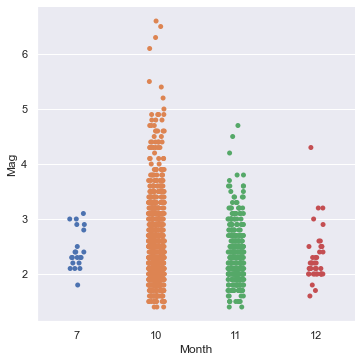

In [522]:
earthquake_6_region = earthquakes.loc[earthquakes.Province == 'Tulunan ']
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=earthquake_6_region.Month, y=earthquake_6_region.Mag, data=earthquake_6_region)

In [523]:
earthquake_6_region.describe()

,Mag,Month,Day
count,1355.000000,1355.000000,1355.000000
mean,2.516236,10.277491,19.307749
std,0.676566,0.668816,9.800170
min,1.400000,7.000000,1.000000
25%,2.000000,10.000000,15.000000
50%,2.400000,10.000000,19.000000
75%,2.800000,11.000000,29.000000
max,6.600000,12.000000,31.000000


Text(0.5, 1.0, 'Davao del Sur')

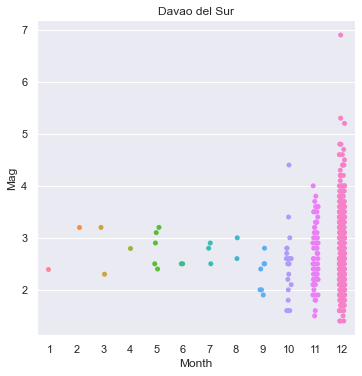

In [540]:
earthquake_6_region = earthquakes.loc[earthquakes.Region == 'Davao Del Sur']
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=earthquake_6_region.Month, y=earthquake_6_region.Mag, data=earthquake_6_region)
plt.title("Davao del Sur")

In [525]:
earthquake_6_region.describe()

,Mag,Month,Day
count,714.000000,714.000000,714.000000
mean,2.672829,11.651261,18.761905
std,0.649256,1.184379,6.174363
min,1.400000,1.000000,1.000000
25%,2.200000,12.000000,16.000000
50%,2.500000,12.000000,18.000000
75%,3.100000,12.000000,23.000000
max,6.900000,12.000000,31.000000


Text(0.5, 1.0, 'Magnitude Max & Avg')

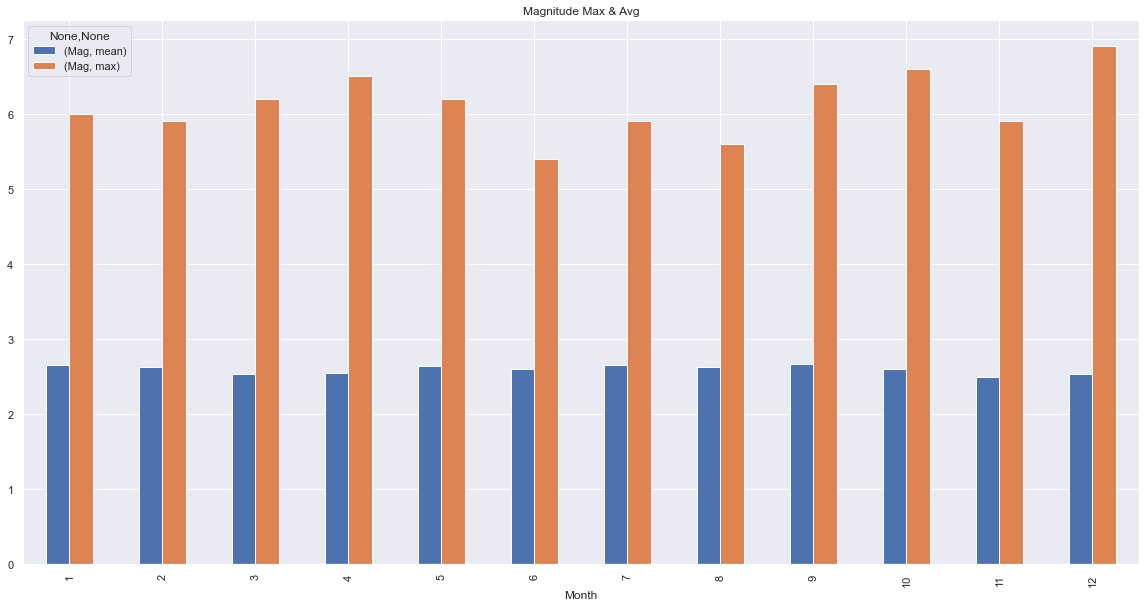

In [474]:
plt.rcParams["figure.figsize"] = (20,10)
earthquakes.groupby('Month').agg({'Mag':['mean', 'max']}).plot.bar()
plt.title('Magnitude Max & Avg')

In [359]:
earthquakes.Region.loc[(earthquakes.Mag >= 5.0)]

101        Eastern Samar
152              Cagayan
214     Davao Occidental
277     Davao Occidental
311     Davao Occidental
              ...       
237     Davao Occidental
815        Davao Del Sur
1253       Davao Del Sur
1258       Davao Del Sur
1523    Davao Occidental
Name: Region, Length: 76, dtype: object

In [80]:
month_of_earthquakes = earthquakes.Datetime.dt.month

In [81]:
month_of_earthquakes.head()

0    1
1    1
2    1
3    1
4    1
Name: Datetime, dtype: int64

<AxesSubplot:xlabel='Datetime', ylabel='Count'>

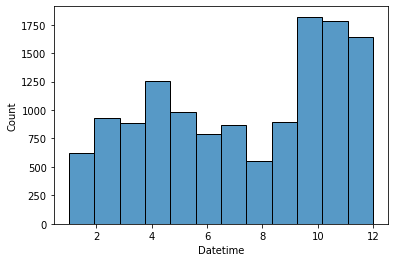

In [82]:
sns.histplot(month_of_earthquakes, kde=False, bins=12)

<AxesSubplot:xlabel='count', ylabel='Month'>

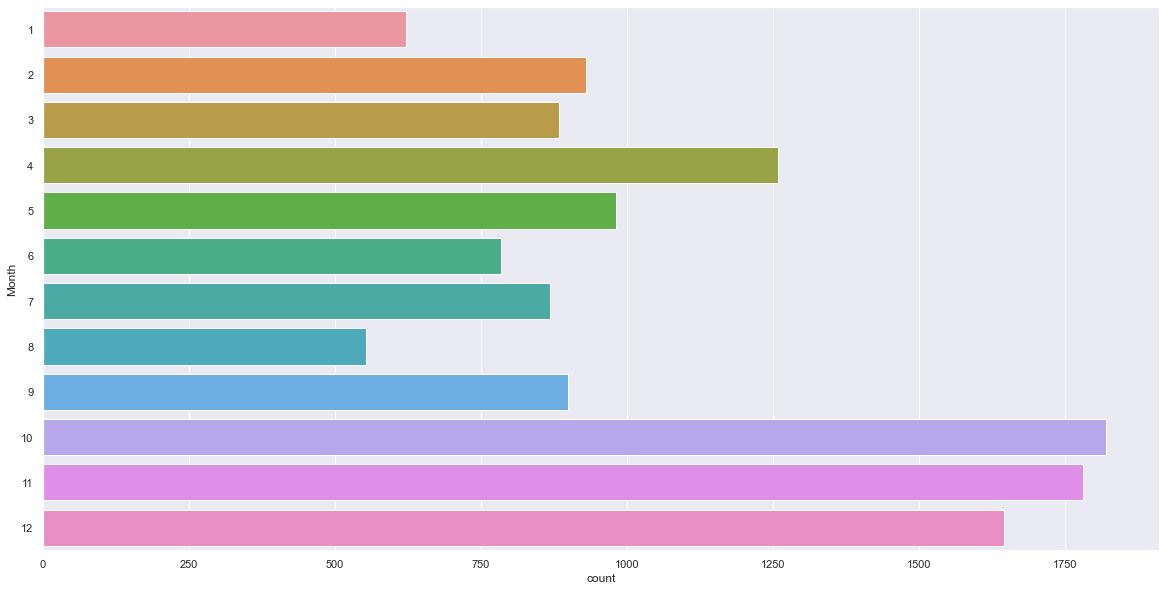

In [508]:
plt.rcParams["figure.figsize"] = (20,10)
sns.countplot(y=earthquakes.Month, data=earthquakes)

,Datetime,Latitude,Longitude,Depth,Mag,Location,Month,Day,Province,Region
1258,2019-12-15 14:11:00,6.76,125.13,9,6.9,013 km N 75° W of Matanao (Davao Del Sur),12,15,Matanao,Davao Del Sur


Text(0.5, 1.0, 'Matanao')

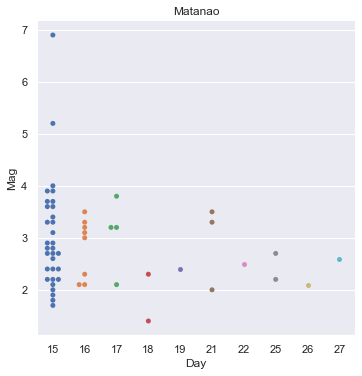

In [542]:
month_earthquake = earthquakes.copy()
month_earthquake = month_earthquake.loc[(month_earthquake.Month == 12)&(month_earthquake.Province == 'Matanao ')]
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=month_earthquake.Day, y=month_earthquake.Mag, data=month_earthquake, kind='swarm')
plt.title('Matanao')

In [526]:
month_earthquake.describe()

,Mag,Month,Day
count,55.000000,55.0,55.000000
mean,2.889091,12.0,16.709091
std,0.907310,0.0,3.101211
min,1.400000,12.0,15.000000
25%,2.200000,12.0,15.000000
50%,2.700000,12.0,15.000000
75%,3.300000,12.0,17.000000
max,6.900000,12.0,27.000000


Text(0.5, 1.0, 'Tulunan')

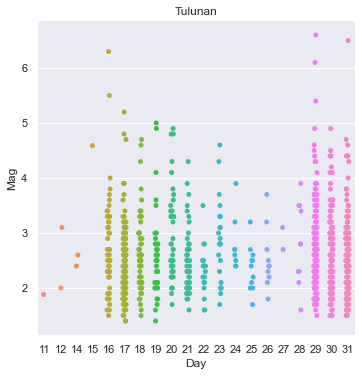

In [541]:
month_earthquake = earthquakes.copy()
month_earthquake = month_earthquake.loc[(month_earthquake.Month == 10)&(month_earthquake.Province == 'Tulunan ')]
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=month_earthquake.Day, y=month_earthquake.Mag, data=month_earthquake)
plt.title('Tulunan')

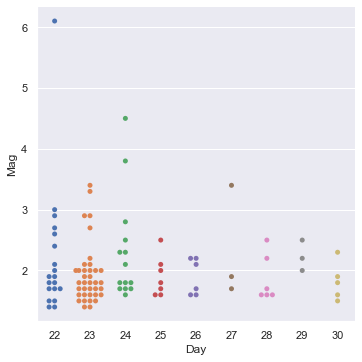

In [543]:
month_earthquake = earthquakes.copy()
month_earthquake = month_earthquake.loc[(month_earthquake.Month == 4)&(month_earthquake.Province == 'Castillejos ')]
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=month_earthquake.Day, y=month_earthquake.Mag, data=month_earthquake, kind='swarm')

In [544]:
month_earthquake.describe()

,Mag,Month,Day
count,100.000000,100.0,100.000000
mean,2.049000,4.0,24.220000
std,0.682316,0.0,2.285572
min,1.400000,4.0,22.000000
25%,1.675000,4.0,23.000000
50%,1.800000,4.0,23.000000
75%,2.200000,4.0,25.000000
max,6.100000,4.0,30.000000


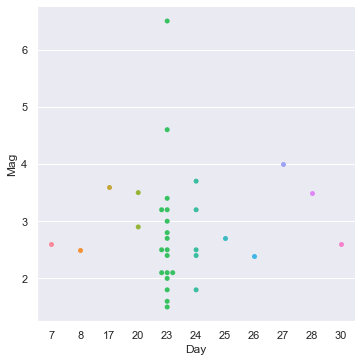

In [545]:
month_earthquake = earthquakes.copy()
month_earthquake = month_earthquake.loc[(month_earthquake.Month == 4)&(month_earthquake.Province == 'San Julian ')]
plt.rcParams["figure.figsize"] = (20,10)
sns.catplot(x=month_earthquake.Day, y=month_earthquake.Mag, data=month_earthquake, kind='swarm')

In [546]:
month_earthquake.describe()

,Mag,Month,Day
count,33.000000,33.0,33.000000
mean,2.845455,4.0,22.484848
std,0.965042,0.0,4.451974
min,1.500000,4.0,7.000000
25%,2.400000,4.0,23.000000
50%,2.600000,4.0,23.000000
75%,3.200000,4.0,24.000000
max,6.500000,4.0,30.000000


### Magnitude for October 2019

<AxesSubplot:xlabel='Datetime', ylabel='Mag'>

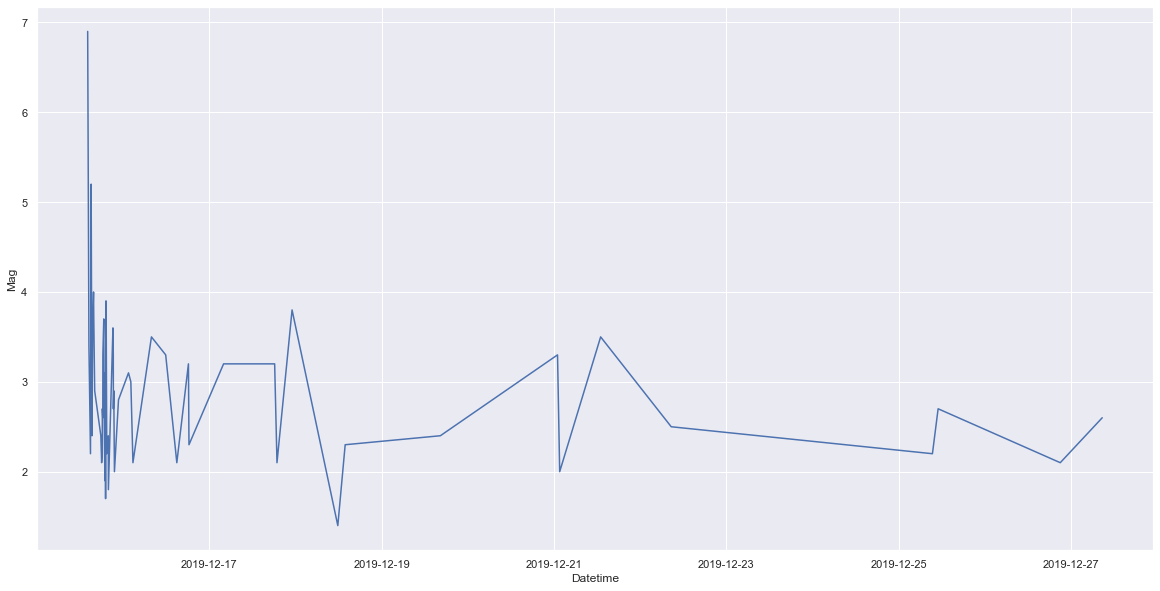

In [178]:
october_earthquakes = earthquakes.loc[(earthquakes.Datetime.dt.month == 12) & (earthquakes.Province == 'Matanao ')]
plt.rcParams["figure.figsize"] = (20,10)
sns.lineplot(data=october_earthquakes, x=october_earthquakes.Datetime, y=october_earthquakes.Mag)

In [602]:
tweets = pd.read_csv('datasets/Workflow 115869 - twitter-512960.csv')
tweets.created_at = pd.to_datetime(tweets.created_at )

# tweets['created_at '] = pd.to_datetime(earthquakes['created_at '], format="%d %B %Y - %I:%M %p")

In [603]:
tweets['Year'] = tweets.created_at.dt.year
tweets['Month'] = tweets.created_at.dt.month
tweets['Day'] = tweets.created_at.dt.day

In [604]:
# list(tweets.text.apply(lambda x:x.split(" ")))
words = list(tweets.text.apply(lambda x:x.split(" ")))


In [605]:
flatten = [item for sublist in words for item in sublist]
flatten.remove('ang')
flatten.remove('and')
flatten.remove('for')
flatten.remove('the')

In [606]:
with open('new_words.txt', 'w') as f:
    for item in flatten:
        f.write("%s\n" % item)

In [670]:
no_depth_earthquakes = earthquakes.copy()
size = []
no_depth_earthquakes = no_depth_earthquakes.drop(columns='Depth')
for batch in range(0, 13028, 2000):
    new_df = no_depth_earthquakes[batch:2000+batch]
    new_df.to_csv('datasets/no_depth_earthquake/'+str(batch)+'.csv')
    size.append(len(new_df))
    print(len(new_df))
print('TOTAL ROWS', sum(size))

2000
2000
2000
2000
2000
2000
1028
TOTAL ROWS 13028


In [612]:
dropped_depth.describe()

,Mag,Month,Day
count,13028.000000,13028.00000,13028.000000
mean,2.581770,7.36268,16.154513
std,0.664875,3.55059,8.962200
min,1.200000,1.00000,1.000000
25%,2.100000,4.00000,9.000000
50%,2.500000,8.00000,16.000000
75%,2.900000,11.00000,24.000000
max,6.900000,12.00000,31.000000
